# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
%matplotlib widget

### Rozwiązanie

## Zapisywanie punktów do pliku i wczytywanie ich

Aby zapisać wykres do pliku należy skorzystać z funkcji writeToFile(), która w argumentach przyjmuje nazwę pliku i obiekt klasy Plot. Nazwa pliku powinna mieć rozszerzenie .json.

In [3]:
def writeToFile(fileName: str, pointset: Plot) -> None:
    with open(fileName, 'w') as f:
        f.write(pointset.toJson())
    f.close()


Aby wykres z pliku należy skorzystać z funkcji readFromFile(), która w argumencie przyjmuje nazwę pliku, a zwraca obiekt klasy Plot. Nazwa pliku powinna mieć rozszerzenie .json.

In [4]:
def readFromFile(fileName: str) -> Plot:
    with open(fileName, 'r') as f:
        json = f.read()
    f.close()
    return Plot(json=json)


Funkcja emptyCanvas tworzy obszar na którym można zadać odcinki do sprawdzenia algorytmu przy pomocy narzędzia wizualizującego. W parametrach można podać szerokość i wysokość obszaru.

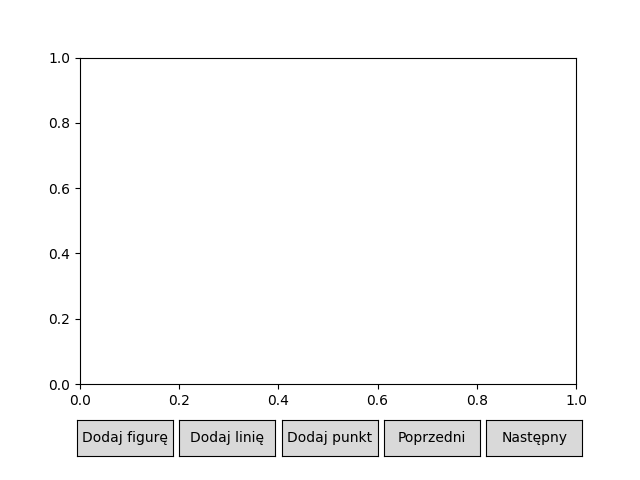

In [5]:
def emptyCanvas(xLim: int=10, yLim: int=10) -> Plot:
    return Plot(points=[PointsCollection([(xLim, yLim), (0, 0)], color='white')])
newDrawing = emptyCanvas()
newDrawing.draw()

Po narysowaniu odcinków te mogą zostać zapisane do pliku json.

In [6]:
writeToFile("sampleLines.json", Plot(scenes=[newDrawing.get_added_elements()]))


Aby uzyskać informację o narysowanych odcinkach można użyć funkcji getSegmentsFromScene() - w przypadku, gdy odcinki zostały wczytane z zewnętrznego pliku do zmiennej, albo getSegmentsAddedToPlot(), gdy chcemy otrzymać odcinki narysowane na wykresie. Funkcje zwracają listę par dwóch współrzędnych oznaczających punkty krańce odcinków.

In [7]:
def getSegmentsFromScene(p: Plot) -> list:
    return p.scenes[0].lines[0].lines

# p = readFromFile("sampleLines.json")
# p.draw()
# edges = getSegmentsFromScene(p)
# # print(edges)

def getSegmentsAddedToPlot(polygon: Plot) -> list:
    return polygon.get_added_lines()[0].lines

# edges2 = getSegmentsAddedToPlot(newDrawing)
# # print(edges2)


## Generowanie losowych odcinków

Poniższa funkcja odpowiada za wylosowanie wybranej liczby odcinków na zadanym przedziale

In [8]:
import random
def genSegments(n, xMin, xMax, yMin, yMax):
    xPoints = set()
    segments = []
    i = 0
    while i < n:
        x1 = random.uniform(xMin, xMax)
        x2 = random.uniform(xMin, xMax)
        if x1 in xPoints or x2 in xPoints: continue
        y1 = random.uniform(yMin, yMax)
        y2 = random.uniform(yMin, yMax)
        if x1 == x2: continue
        segments.append([[x1, y1], [x2, y2]])
        xPoints.add(x1)
        xPoints.add(x2)
        i += 1
    return segments
        

In [9]:
testSegments = genSegments(5, 0, 10, 0, 10)

Wygenerowane punkty można zwizualizować na wykresie przy pomocy poniższej funkcji

In [10]:
def genSegmentsPlot(segments, points = None):
    a = LinesCollection(segments)
    if points != None:
        b = PointsCollection(points, color='violet')
        return Plot(points=[b], lines=[a])
    return Plot(lines=[a])


Wygenerowane punkty można teraz wyświetlić, oraz je wypisać.

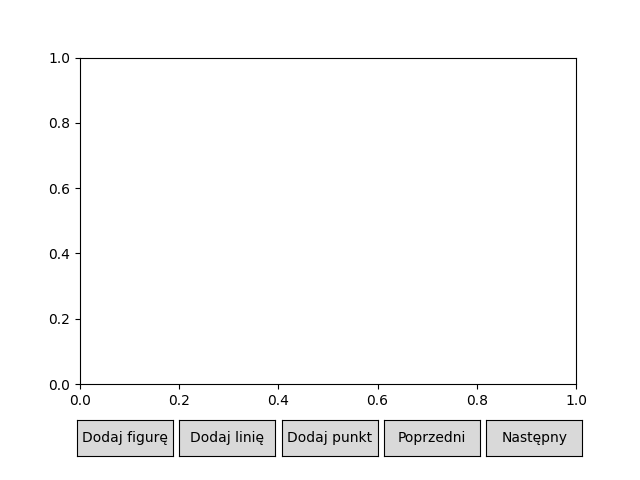

[[[4.881062085235138, 1.4175893810602314], [4.185841076518786, 6.997660883911621]], [[3.466876416878729, 1.506195698620627], [9.759825656381015, 8.061131252553386]], [[6.414417967889872, 0.9613142871856339], [1.7039911289302123, 0.11966403540965898]], [[0.9664079569385775, 4.153627807378744], [7.28318768345273, 1.4770588318254252]], [[4.6003674872517415, 9.502196255354747], [4.130884230849955, 4.060210564744915]]]


In [11]:
drawing = genSegmentsPlot(testSegments)
drawing.draw()
print(getSegmentsFromScene(drawing))



## Sprawdzanie przecięcia dwóch odcinków

Poniższa funkcja przyjmuje w argumencie dwa odcinki i sprawdza czy się przecinają, a jeżeli tak, to zwraca punkt ich przecięcia

In [12]:
def areIntersecting(seg1, seg2):
    seg1 = seg1.getIterable()
    seg2 = seg2.getIterable()
    x11, y11 = seg1[0]
    x12, y12 = seg1[1]
    x21, y21 = seg2[0]
    x22, y22 = seg2[1]
    
    a1 = (y11 - y12) / (x11 - x12)
    a2 = (y21 - y22) / (x21 - x22)
    if a1 == a2: return None    
    b1 = y11 - a1 * x11
    b2 = y21 - a2 * x21
    # a1x + b1 = a2x + b2 --> x = (b2 - b1) / (a1 - a2)
    x = (b2 - b1) / (a1 - a2)
    y = a1 * x + b1
    if x < min(x11, x12) or x > max(x11, x12) or x < min(x21, x22) or x > max(x21, x22):
        return None
    if y < min(y11, y12) or y > max(y11, y12) or y < min(y21, y22) or y > max(y21, y22):
        return None
    return (x, y)

# Reprezentacja punktu, odcinku i zbioru odcinków

In [235]:
from sortedcontainers import SortedSet
START = 0
END = 1
CROSS = 2

class Point():
    def __init__(self, coords) -> None:
        self.x = coords[0]
        self.y = coords[1]
        self.edgeIndex = None
        self.type = None
        self.edgeCrossingIdx = (None, None)
        
    def getIterable(self):
        return (self.x, self.y)
    
    def __str__(self):
        return str(self.getIterable())
    
    def __repr__(self):
        return self.__str__()
    
class Segment():
    def __init__(self, seg, idx = None):
        p1 = seg[0]
        p2 = seg[1]
        if p1.x < p2.x:
            self.start = p1
            p1.type = START
            self.end = p2
            p2.type = END
        else:
            self.start = p2
            p2.type = START
            self.end = p1
            p1.type = END
        self.sortValue = (self.start, 0)
        self.idx = idx
        
    def setPointsIdx(self, idx):
        self.start.edgeIndex = idx
        self.end.edgeIndex = idx
    
    def getIterable(self):
        return [self.start.getIterable(), self.end.getIterable()]
        
    def __str__(self):
        return str([self.start, self.end])
    
    def __repr__(self):
        return self.__str__()

class SegmentCloud():
    
    def __init__(self, segments):
        self.segments = []
        self.points = []
        self.minY = float("inf")
        self.maxY = -float("inf")
        for i, segment in enumerate(segments):
            p1 = segment[0]
            p2 = segment[1]
            p1 = Point(p1)
            p2 = Point(p2)
            seg = Segment((p1, p2), i)
            self.segments.append(seg)
            self.points.append(p1)
            self.points.append(p2)
            self.segments[i].setPointsIdx(i)
            self.maxY = max(self.maxY, p1.y, p2.y)
            self.minY = min(self.minY, p1.y, p2.y)
    
    def hasIntersection(self):
        sweep = SortedSet(key=lambda x : (x.sortValue[0].y, x.sortValue[1]))
        events = SortedSet(self.points, key=lambda x : (x.x))
        for el in events:
            if el.type == START:
                toInsert = self.segments[el.edgeIndex]
                sweep.add(toInsert)
                i = sweep.index(toInsert)
                if i > 0 and areIntersecting(sweep[i], sweep[i-1]) != None:
                    return True
                if i < len(sweep) - 1 and areIntersecting(sweep[i], sweep[i+1]) != None:
                    return True
            if el.type == END:
                toRemove = self.segments[el.edgeIndex]
                i = sweep.index(toRemove)
                if i > 0 and i < len(sweep) - 1 and areIntersecting(sweep[i-1], sweep[i+1]) != None:
                    return True
                sweep.remove(toRemove)
        return False
    
    def getLC(self, segmentSet, col="navy"):
        out = []
        for el in segmentSet:
            out.append(el.getIterable())
        return LinesCollection(out, color=col)
    
    def getPC(self, pointsSet, col="navy"):
        out = []
        for el in pointsSet:
            out.append(el.getIterable())
        return PointsCollection(out, color=col)
    
    def getSweep(self, xCoord, col="red"):
        return LinesCollection([[[xCoord, self.minY], [xCoord, self.maxY]]], color=col)
    
    def hasIntersectionAnimation(self):
        scenes = []
        processedPoints = []
        processedLines = []
        scenes.append(Scene(lines=[self.getLC(self.segments)],
                            points=[self.getPC(self.points)]))
        sweep = SortedSet(key=lambda x : (x.sortValue[0].y, x.sortValue[1]))
        events = SortedSet(self.points, key=lambda x : (x.x))
        for el in events:
            scenes.append(Scene(lines=[self.getLC(self.segments),
                                       self.getLC(processedLines, "lightgray"),
                                       self.getLC(list(sweep), "lime"),
                                       self.getSweep(el.x)],
                                points=[self.getPC(self.points),
                                        self.getPC(processedPoints, "lightgray"),
                                        self.getPC([el], "lime")]))
            if el.type == START:
                toInsert = self.segments[el.edgeIndex]
                sweep.add(toInsert)
                i = sweep.index(toInsert)
                scenes.append(Scene(lines=[self.getLC(self.segments),
                                       self.getLC(processedLines, "lightgray"),
                                       self.getLC(list(sweep), "lime"),
                                       self.getSweep(el.x)],
                                points=[self.getPC(self.points),
                                        self.getPC(processedPoints, "lightgray"),
                                        self.getPC([el], "lime")]))
                if i > 0 and areIntersecting(sweep[i], sweep[i-1]) != None:
                    intersection = areIntersecting(sweep[i], sweep[i-1])
                    scenes.append(Scene(lines=[self.getLC(self.segments),
                                        self.getLC(processedLines, "lightgray"),
                                        self.getLC(list(sweep), "lime"),
                                        self.getSweep(el.x)],
                                    points=[self.getPC(self.points),
                                            self.getPC(processedPoints, "lightgray"),
                                            self.getPC([el], "lime"),
                                            self.getPC([Point(intersection)], "red")]))
                    return scenes
                if i < len(sweep) - 1 and areIntersecting(sweep[i], sweep[i+1]) != None:
                    intersection = areIntersecting(sweep[i], sweep[i+1])
                    scenes.append(Scene(lines=[self.getLC(self.segments),
                                        self.getLC(processedLines, "lightgray"),
                                        self.getLC(list(sweep), "lime"),
                                        self.getSweep(el.x)],
                                    points=[self.getPC(self.points),
                                            self.getPC(processedPoints, "lightgray"),
                                            self.getPC([el], "lime"),
                                            self.getPC([Point(intersection)], "red")]))
                    return scenes
            if el.type == END:
                toRemove = self.segments[el.edgeIndex]
                i = sweep.index(toRemove)
                if i > 0 and i < len(sweep) - 1 and areIntersecting(sweep[i-1], sweep[i+1]) != None:
                    return scenes
                sweep.remove(toRemove)
                processedLines.append(toRemove)
            processedPoints.append(el)
        scenes.append(Scene(lines=[self.getLC(self.segments),
                                self.getLC(processedLines, "lightgray"),
                                self.getLC(list(sweep), "lime")],
                        points=[self.getPC(self.points),
                                self.getPC(processedPoints, "lightgray")]))
        return scenes
    
    def updateSweep(self, sweep, x):
        newSweep = SortedSet(key=lambda x : (x.sortValue[0].y, x.sortValue[1]))
        for el in sweep:
                seg = el.getIterable()
                x11, y11 = seg[0]
                x12, y12 = seg[1]
                a1 = (y11 - y12) / (x11 - x12)
                b1 = y11 - a1 * x11
                p = Point((x, a1 * x + b1))
                el.sortValue = (p, 0)
                newSweep.add(el)
        sweep.update(newSweep)
        
    def intersections(self):
        intersections = set()
        intersectionsPoints = []
        sweep = SortedSet(key=lambda x: (x.sortValue[0].y, x.sortValue[1]))
        event = SortedSet(self.points, key=lambda x: x.x)
        while len(event) > 0:
            
            print("start")
            for el in sweep:
                print(el)
            currEvent = event[0]
            print("before update", sweep)
            self.updateSweep(sweep, currEvent.x)
            print("after update ", sweep )
            if currEvent.type == END:
                print("IN END")
                toRemove = self.segments[currEvent.edgeIndex]
                print(toRemove)
                print(sweep)
                i = sweep.index(toRemove)
                if i > 0 and i < len(sweep) - 1 and areIntersecting(sweep[i-1], sweep[i+1]) != None:
                    toCheck = (sweep[i-1].idx, sweep[i+1].idx)
                    if toCheck not in intersections and toCheck[::-1] not in intersections:
                        newEvent = Point(areIntersecting(sweep[i-1], sweep[i+1]))
                        newEvent.type = CROSS
                        newEvent.edgeCrossingIdx = toCheck
                        intersectionsPoints.append(newEvent)
                        event.add(newEvent)
                        intersections.add(toCheck)
                sweep.remove(toRemove)
                # self.updateSweep(sweep, currEvent.x)
            if currEvent.type == START:
                # self.updateSweep(sweep, currEvent.x)
                print("in START")
                toInsert = self.segments[currEvent.edgeIndex]
                sweep.add(toInsert)
                i = sweep.index(toInsert)
                if i > 0 and areIntersecting(sweep[i], sweep[i-1]) != None:
                    toCheck = (sweep[i].idx, sweep[i-1].idx)
                    newEvent = Point(areIntersecting(sweep[i], sweep[i-1]))
                    newEvent.type = CROSS
                    newEvent.edgeCrossingIdx = toCheck
                    event.add(newEvent)
                    intersectionsPoints.append(newEvent)
                    intersections.add(toCheck)
                if i < len(sweep) - 1 and areIntersecting(sweep[i+1], sweep[i]):
                    toCheck = (sweep[i].idx, sweep[i+1].idx)
                    newEvent = Point(areIntersecting(sweep[i+1], sweep[i]))
                    newEvent.type = CROSS
                    newEvent.edgeCrossingIdx = toCheck
                    event.add(newEvent)
                    intersectionsPoints.append(newEvent)
                    intersections.add(toCheck)
            if currEvent.type == CROSS:
                # self.updateSweep(sweep, currEvent.x)
                print("IN CROSS", currEvent.y==currEvent.y)
                j, k = currEvent.edgeCrossingIdx
                change1 = self.segments[j]
                change2 = self.segments[k]
                h, i = sweep.index(change1), sweep.index(change2)
                # print("before change: ", sweep)
                sweep.remove(change1)
                sweep.remove(change2)
                if change1.start.y < change2.start.y:
                    # change1.sortValue , change2.sortValue = change2.sortValue, change1.sortValue #?
                    change1.sortValue = (currEvent, 1)
                    change2.sortValue = (currEvent, 0)
                    sweep.add(change1)
                    sweep.add(change2)
                    i, h = sweep.index(change1), sweep.index(change2)
                    if h < len(sweep) - 1 and areIntersecting(sweep[h], sweep[h+1]):
                        toCheck = (sweep[h].idx, sweep[h+1].idx)
                        if toCheck not in intersections and toCheck[::-1] not in intersections:
                            newEvent = Point(areIntersecting(sweep[h+1], sweep[h]))
                            newEvent.type = CROSS
                            newEvent.edgeCrossingIdx = toCheck
                            event.add(newEvent)
                            intersectionsPoints.append(newEvent)
                            intersections.add(toCheck)
                    # if h > 0 and areIntersecting(sweep[h], sweep[h-1]): #??
                    #     toCheck = (sweep[h].idx, sweep[h-1].idx)
                    #     if toCheck not in intersections and toCheck[::-1] not in intersections:
                    #         newEvent = Point(areIntersecting(sweep[h-1], sweep[h]))
                    #         newEvent.type = CROSS
                    #         newEvent.edgeCrossingIdx = toCheck
                    #         event.add(newEvent)
                    #         intersectionsPoints.append(newEvent)
                    #         intersections.add(toCheck)
                    if i > 0 and areIntersecting(sweep[i], sweep[i-1]):
                        toCheck = (sweep[i].idx, sweep[i-1].idx) 
                        if toCheck not in intersections and toCheck[::-1] not in intersections:
                            newEvent = Point(areIntersecting(sweep[i-1], sweep[i]))
                            newEvent.type = CROSS
                            newEvent.edgeCrossingIdx = toCheck
                            event.add(newEvent)
                            intersectionsPoints.append(newEvent)
                            intersections.add(toCheck)
                    # if i < len(sweep) - 1 and areIntersecting(sweep[i], sweep[i+1]): #??
                    #     toCheck = (sweep[i].idx, sweep[i+1].idx) 
                    #     if toCheck not in intersections and toCheck[::-1] not in intersections:
                    #         newEvent = Point(areIntersecting(sweep[i+1], sweep[i]))
                    #         newEvent.type = CROSS
                    #         newEvent.edgeCrossingIdx = toCheck
                    #         event.add(newEvent)
                    #         intersectionsPoints.append(newEvent)
                    #         intersections.add(toCheck)
                else:
                    # change1.sortValue , change2.sortValue = change2.sortValue, change1.sortValue #?
                    change1.sortValue = (currEvent, 0)
                    change2.sortValue = (currEvent, 1)
                    sweep.add(change1)
                    sweep.add(change2)
                    i, h = sweep.index(change1), sweep.index(change2)
                    if h < len(sweep) - 1 and areIntersecting(sweep[h], sweep[h+1]):
                        toCheck = (sweep[h].idx, sweep[h+1].idx)
                        if toCheck not in intersections and toCheck[::-1] not in intersections:
                            newEvent = Point(areIntersecting(sweep[h+1], sweep[h]))
                            newEvent.type = CROSS
                            newEvent.edgeCrossingIdx = toCheck
                            event.add(newEvent)
                            intersectionsPoints.append(newEvent)
                            intersections.add(toCheck)
                    # if h > 0 and areIntersecting(sweep[h], sweep[h-1]): #??
                    #     toCheck = (sweep[h].idx, sweep[h-1].idx)
                    #     if toCheck not in intersections and toCheck[::-1] not in intersections:
                    #         newEvent = Point(areIntersecting(sweep[h-1], sweep[h]))
                    #         newEvent.type = CROSS
                    #         newEvent.edgeCrossingIdx = toCheck
                    #         event.add(newEvent)
                    #         intersectionsPoints.append(newEvent)
                    #         intersections.add(toCheck)
                    if i > 0 and areIntersecting(sweep[i], sweep[i-1]):
                        toCheck = (sweep[i].idx, sweep[i-1].idx) 
                        if toCheck not in intersections and toCheck[::-1] not in intersections:
                            newEvent = Point(areIntersecting(sweep[i-1], sweep[i]))
                            newEvent.type = CROSS
                            newEvent.edgeCrossingIdx = toCheck
                            event.add(newEvent)
                            intersectionsPoints.append(newEvent)
                            intersections.add(toCheck)
                    # if i < len(sweep) - 1 and areIntersecting(sweep[i], sweep[i+1]): #??
                    #     toCheck = (sweep[i].idx, sweep[i+1].idx) 
                    #     if toCheck not in intersections and toCheck[::-1] not in intersections:
                    #         newEvent = Point(areIntersecting(sweep[i+1], sweep[i]))
                    #         newEvent.type = CROSS
                    #         newEvent.edgeCrossingIdx = toCheck
                    #         event.add(newEvent)
                    #         intersectionsPoints.append(newEvent)
                    #         intersections.add(toCheck)
            print("end  ")
            for el in sweep: print(el)
            event.remove(currEvent)
            # print(event)
        return intersectionsPoints
    
    def getIntersectionsScenes(self):
        intersections = self.intersections()
        scenes = []
        scenes.append(Scene(lines=[self.getLC(self.segments)],
                            points=[self.getPC(self.points)]))
        scenes.append(Scene(lines=[self.getLC(self.segments)],
                            points=[self.getPC(self.points),
                                    self.getPC(intersections, "red")]))
        return scenes
        
            
                
                    

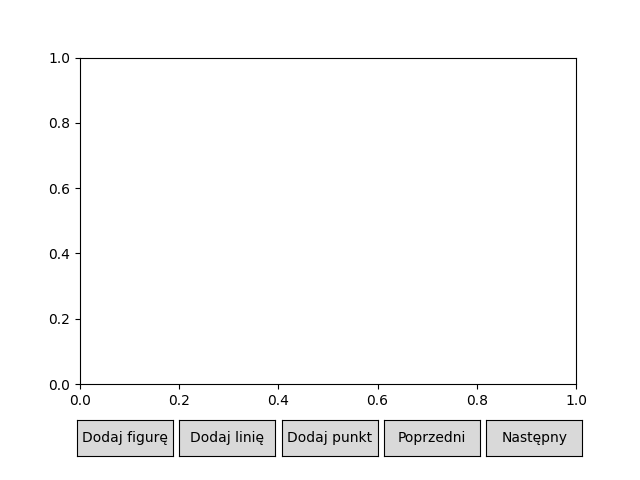

In [241]:
t = genSegments(20, 0, 100, 0, 100)
dr = genSegmentsPlot(t)
# dr = emptyCanvas(100, 100)
dr.draw()


start
before update SortedSet([], key=<function SegmentCloud.intersections.<locals>.<lambda> at 0x000001BCC66DF600>)
after update  SortedSet([], key=<function SegmentCloud.intersections.<locals>.<lambda> at 0x000001BCC66DF600>)
in START
end  
[(1.172121960405681, 1.386801872126664), (47.63844685440275, 40.484960290314376)]
start
[(1.172121960405681, 1.386801872126664), (47.63844685440275, 40.484960290314376)]
before update SortedSet([[(1.172121960405681, 1.386801872126664), (47.63844685440275, 40.484960290314376)]], key=<function SegmentCloud.intersections.<locals>.<lambda> at 0x000001BCC66DF600>)
after update  SortedSet([[(1.172121960405681, 1.386801872126664), (47.63844685440275, 40.484960290314376)]], key=<function SegmentCloud.intersections.<locals>.<lambda> at 0x000001BCC66DF600>)
in START
end  
[(1.172121960405681, 1.386801872126664), (47.63844685440275, 40.484960290314376)]
[(6.881267100937416, 39.3447158394451), (95.83795340612863, 91.33887521939437)]
start
[(1.172121960405681,

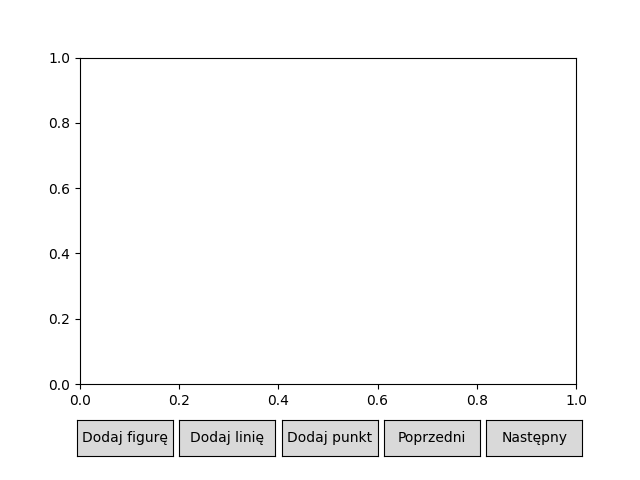

start
before update SortedSet([], key=<function SegmentCloud.intersections.<locals>.<lambda> at 0x000001BCC69E22A0>)
after update  SortedSet([], key=<function SegmentCloud.intersections.<locals>.<lambda> at 0x000001BCC69E22A0>)
in START
end  
[(1.172121960405681, 1.386801872126664), (47.63844685440275, 40.484960290314376)]
start
[(1.172121960405681, 1.386801872126664), (47.63844685440275, 40.484960290314376)]
before update SortedSet([[(1.172121960405681, 1.386801872126664), (47.63844685440275, 40.484960290314376)]], key=<function SegmentCloud.intersections.<locals>.<lambda> at 0x000001BCC69E22A0>)
after update  SortedSet([[(1.172121960405681, 1.386801872126664), (47.63844685440275, 40.484960290314376)]], key=<function SegmentCloud.intersections.<locals>.<lambda> at 0x000001BCC69E22A0>)
in START
end  
[(1.172121960405681, 1.386801872126664), (47.63844685440275, 40.484960290314376)]
[(6.881267100937416, 39.3447158394451), (95.83795340612863, 91.33887521939437)]
start
[(1.172121960405681,

In [242]:
t = SegmentCloud(getSegmentsFromScene(dr))
# t = SegmentCloud(getSegmentsAddedToPlot(dr))
a = Plot(scenes=t.getIntersectionsScenes())

a.draw()
print(t.intersections())


In [ ]:
import sortedcontainers

class basicSweep():
    def __init__(self) -> None:
        self.sweep = sortedcontainers.SortedSet(key=lambda x : (x.sortValue[0].y, x.sortValue[1]))
    
    def add(self, segment):
        self.sweep.add(segment)
    
    def remove(self, segment):
        self.sweep.remove(segment)

class basicEvent():
    def __init__(self, arg : SegmentCloud) -> None:
        self.events = sortedcontainers.SortedSet(key=lambda x : (x.x))
        for el in arg.points:
            self.events.add(el)

def isIntersection(segments : SegmentCloud) -> bool:
    
    sweep = sortedcontainers.SortedSet(key=lambda x : (x.sortValue[0].y, x.sortValue[1]))
    events = sortedcontainers.SortedSet(key=lambda x : (x.x))
    for el in segments.points:
        events.add(el)
    
    for el in events:
        if el.type == START:
            toInsert = segments.segments[el.edgeIndex]
            sweep.add(toInsert)
            i = sweep.index(toInsert)
            if i > 0 and areIntersecting(sweep[i], sweep[i-1]) != None:
                return True
            if i < len(sweep) - 1 and areIntersecting(sweep[i], sweep[i+1]) != None:
                return True
        if el.type == END:
            toRemove = segments.segments[el.edgeIndex]
            i = sweep.index(toRemove)
            if i > 0 and i < len(sweep) - 1 and areIntersecting(sweep[i-1], sweep[i+1]) != None:
                return True
            sweep.remove(toRemove)
    return False
s = getSegmentsAddedToPlot(dr)
print(s)
sc = SegmentCloud(s)
print(sc.segments)
print(isIntersection(sc))

[[(3.2488154903534925, 7.349596808938421), (6.5088961355147825, 8.562832103056067)], [(1.6298638774502665, 7.956214455997244), (4.7790574258373635, 4.316508573644302)], [(3.3818800064825245, 6.473371318742342), (6.109702587127686, 6.978886024624695)], [(8.238734845192202, 8.630234063840383), (6.0653477484180085, 2.530356612859988)], [(7.7508316193857505, 1.2834203383501839), (1.7629283935792985, 0.7442046520756733)]]
[[(3.2488154903534925, 7.349596808938421), (6.5088961355147825, 8.562832103056067)], [(1.6298638774502665, 7.956214455997244), (4.7790574258373635, 4.316508573644302)], [(3.3818800064825245, 6.473371318742342), (6.109702587127686, 6.978886024624695)], [(6.0653477484180085, 2.530356612859988), (8.238734845192202, 8.630234063840383)], [(1.7629283935792985, 0.7442046520756733), (7.7508316193857505, 1.2834203383501839)]]
False
